8. Putting it all together with a multi-class classification problem

* Binary classification = one thing or another (cat vs. dog, spam vs. not spam, fraud or not fraud)
* Multi-class classification = more than one thing or another (cat vs. dog vs. chicken)



8.1 Creating a toy multi-class dataset

In [1]:
# Import dependecies
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs # https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
from sklearn.model_selection import train_test_split
from helper_functions import plot_predictions, plot_decision_boundary # For the plot boundary plot

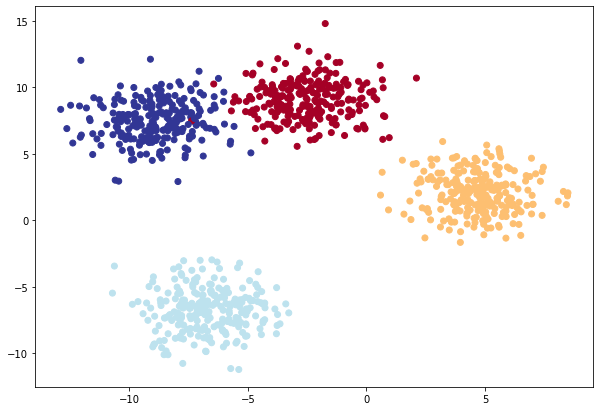

In [3]:
# Creating device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples = 1000,
                           n_features = NUM_FEATURES,
                           centers = NUM_CLASSES,
                           cluster_std = 1.5, # give the clusters a little shakeup
                           random_state = RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                          y_blob,
                                                                          test_size = 0.2,
                                                                          random_state = RANDOM_SEED)
#4. Putting all data on the same device
X_blob_train, X_blob_test = X_blob_train.to(device), X_blob_test.to(device)
y_blob_train, y_blob_test = y_blob_train.to(device), y_blob_test.to(device)

# 5. Plot data
plt.figure(figsize = (10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

In [48]:
X_blob_train[:5], y_blob_train[:5]

(tensor([[ 5.0405,  3.3076],
         [-2.6249,  9.5260],
         [-8.5240, -9.0402],
         [-6.0262, -4.4375],
         [-3.3397,  7.2175]], device='cuda:0'),
 tensor([1, 0, 2, 2, 0], device='cuda:0'))

### 8.2 Building a multi-class classification model in PyTorch

In [50]:
# Build a multi-class classification model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        """
        Initializes multi-class classification
        
        args: 
            input_features (int): Number of input features to the model
            output_features (int): Number of output features (number of output classes)
            hidden_units (int): Number of hidden units between layers, default 8
            
        Returns:
        
        Example:
        
        """
        
        super().__init__()
        #Instantiating things
        
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(), # For non-linearity
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), # For non-linearity
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)
    
# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features = 2,
                   output_features = 4,
                   hidden_units = 8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create a loss function and an optimizer for a multi-class classification model


In [51]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification (SGD and Adam most popular)
optimizer = torch.optim.SGD(params=model_4.parameters(),
                           lr=0.1) # Learning rate is a hyperparameter you can change

# Creating an accuracy function
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() #Counts how many are correct
    
    acc = (correct/len(y_pred))
    return acc

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

IN order to evaluate and train and test our model, we need to convert our model's
outputs (logits) to prediction probabilities and then to prediction labels.

Logits (raw output of the model -> Pred probs (use 'torch.softmax') -> Pred lables (Take the argmax of the prediction probabilities)

In [54]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)
    
y_preds[:10], y_blob_test[:10]

NameError: name 'y_preds' is not defined

In [53]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim = 1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.2907,  0.4866,  0.2833, -0.5598],
        [-0.4353, -0.0612,  0.2928, -0.5800],
        [ 0.0474, -0.8479, -0.5453, -0.2120],
        [-0.2167,  0.5010,  0.2613, -0.5220],
        [-0.3308,  0.2518,  0.0532, -0.5359]], device='cuda:0')
tensor([[0.1750, 0.3807, 0.3106, 0.1337],
        [0.1855, 0.2697, 0.3842, 0.1605],
        [0.3659, 0.1495, 0.2023, 0.2823],
        [0.1852, 0.3796, 0.2987, 0.1365],
        [0.1971, 0.3530, 0.2894, 0.1606]], device='cuda:0')


In [160]:
torch.sum(y_pred_probs[0]), torch.argmax(y_pred_probs[0])
# probabilities are a sum of 1 for wach index
# Index 0 is has the highest probability

(tensor(1., device='cuda:0'), tensor(1, device='cuda:0'))

In [161]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim = 1) # dim = 1, is to go accross the first dimension
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [162]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

### 8.5 Building a training and testing loop

In [55]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set numbe of epochs
epochs = 100

# Loop through data
for epoch in range(epochs):
    ### Training
    model_4.train()
    
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim = 1).argmax(dim=1)
    
#     print(y_blob_train.shape, y_pred.shape)
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                     y_pred=y_pred)
    
    # Zero grad
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    ### Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                              y_pred=test_preds)
        
    #Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")
    

Epoch: 0 | Loss: 1.47258, Acc: 0.27% | Test Loss: 1.24810, Test Acc: 0.47%
Epoch: 10 | Loss: 0.67197, Acc: 0.78% | Test Loss: 0.61559, Test Acc: 0.77%
Epoch: 20 | Loss: 0.31428, Acc: 0.99% | Test Loss: 0.29951, Test Acc: 1.00%
Epoch: 30 | Loss: 0.16514, Acc: 0.99% | Test Loss: 0.15630, Test Acc: 0.99%
Epoch: 40 | Loss: 0.09997, Acc: 0.99% | Test Loss: 0.09351, Test Acc: 0.99%
Epoch: 50 | Loss: 0.07176, Acc: 0.99% | Test Loss: 0.06557, Test Acc: 0.99%
Epoch: 60 | Loss: 0.05735, Acc: 0.99% | Test Loss: 0.05097, Test Acc: 0.99%
Epoch: 70 | Loss: 0.04892, Acc: 0.99% | Test Loss: 0.04220, Test Acc: 0.99%
Epoch: 80 | Loss: 0.04352, Acc: 0.99% | Test Loss: 0.03646, Test Acc: 0.99%
Epoch: 90 | Loss: 0.03980, Acc: 0.99% | Test Loss: 0.03242, Test Acc: 0.99%


In [79]:
acc = accuracy_fn(y_true=y_blob_train,
                     y_pred=y_pred)

In [82]:
acc

### 8.6 Making an evaluating predictions with a PyTorch multi-class model

In [145]:
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [166]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))

y_preds = torch.softmax(y_logits, dim = 1).argmax(dim = 1)

# y_blob_test[:10], y_pred_probs[:10]

AttributeError: 'NoneType' object has no attribute 'to'

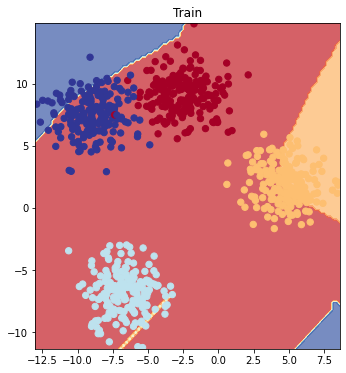

In [149]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [169]:
from torchmetrics import Accuracy
import torchmetrics


In [164]:

# setup metric
torchmetric_accuracy = Accuracy(task = "multiclass", num_classes=4).to(device)

#Caclculate the accuracy
torchmetric_accuracy(y_preds, y_blob_test)

In [171]:
torchmetric_precision = torchmetrics.Precision(task= "multiclass", num_classes=4).to(device)
torchmetric_precision(y_preds,y_blob_test)

tensor(0.9950, device='cuda:0')

In [173]:
torchmetric_recall = torchmetrics.F1Score(task = "multiclass", num_classes=4).to(device)
torchmetric_recall(y_preds,y_blob_test)

tensor(0.9950, device='cuda:0')

In [2]:
torch.cuda.is_available()

True

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [65]:
class Model0(nn.Module):
    def __init__(self, input_feat, out_feats, hidden_units):
        
        super().__init__()
        
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_feat, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=out_feats)            
        )
        
    def forward(self, x):
        return self.layer_stack(x)
    
Model_0 = Model0(input_feat=2,
                 out_feats=4,
                 hidden_units=8).to(device)
Model_0.parameters

<bound method Module.parameters of Model0(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)>

In [69]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(Model_0.parameters(),
                           lr = 0.1)

In [41]:
X_blob_train[:5]

tensor([[ 5.0405,  3.3076],
        [-2.6249,  9.5260],
        [-8.5240, -9.0402],
        [-6.0262, -4.4375],
        [-3.3397,  7.2175]], device='cuda:0')

In [70]:
# Learning loop

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

for epoch in range(epochs):
    ### Training
    
    #1. Forward pass
    y_logits = Model_0(X_blob_train)
    
    loss = loss_fn(y_logits, y_blob_train)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    ### Testing
    Model_0.eval()
    with torch.inference_mode():
        test_logits = Model_0(X_blob_test)
        test_pred = torch.softmax(test_logits, dim = 1).argmax(dim = 1)
        
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true = y_blob_test,
                              y_pred = test_pred)
    #Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.15883, Acc: 0.99% | Test Loss: 1.07554, Test Acc: 0.48%
Epoch: 10 | Loss: 0.64476, Acc: 0.99% | Test Loss: 0.66069, Test Acc: 0.97%
Epoch: 20 | Loss: 0.42535, Acc: 0.99% | Test Loss: 0.43074, Test Acc: 1.00%
Epoch: 30 | Loss: 0.25294, Acc: 0.99% | Test Loss: 0.24508, Test Acc: 0.99%
Epoch: 40 | Loss: 0.11232, Acc: 0.99% | Test Loss: 0.10229, Test Acc: 0.99%
Epoch: 50 | Loss: 0.06627, Acc: 0.99% | Test Loss: 0.05848, Test Acc: 0.99%
Epoch: 60 | Loss: 0.05068, Acc: 0.99% | Test Loss: 0.04293, Test Acc: 0.99%
Epoch: 70 | Loss: 0.04300, Acc: 0.99% | Test Loss: 0.03491, Test Acc: 0.99%
Epoch: 80 | Loss: 0.03836, Acc: 0.99% | Test Loss: 0.02988, Test Acc: 0.99%
Epoch: 90 | Loss: 0.03525, Acc: 0.99% | Test Loss: 0.02663, Test Acc: 0.99%


In [68]:
Model_0(X_blob_test)

tensor([[-7.6459e-01, -7.4120e-01, -1.5777e+00, -1.1376e+00],
        [-9.7256e-02, -9.4310e-01, -5.9631e-01, -1.3715e-01],
        [ 2.5277e-01, -2.3794e-01,  1.8817e-01, -6.5686e-03],
        [-4.1340e-01, -5.2042e-01, -9.3033e-01, -6.9626e-01],
        [-3.1184e-01, -1.3736e+00, -1.1991e+00, -3.8337e-01],
        [-1.4971e-01, -1.0617e+00, -7.1069e-01, -1.6452e-01],
        [ 1.5388e-01, -2.8874e-01,  1.5199e-01, -1.0874e-02],
        [-2.1543e-01, -1.1795e+00, -9.3000e-01, -2.7448e-01],
        [ 2.4432e-01, -2.4716e-01,  1.6492e-01,  6.1044e-03],
        [-2.3286e-01, -1.2120e+00, -9.8487e-01, -3.0037e-01],
        [-1.7742e-01, -1.1008e+00, -8.2929e-01, -2.3689e-01],
        [-9.4082e-01, -7.8985e-01, -1.8480e+00, -1.3347e+00],
        [-2.9723e-01, -1.3458e+00, -1.1543e+00, -3.6287e-01],
        [-2.9006e-01, -1.3393e+00, -1.1146e+00, -3.3518e-01],
        [-3.3713e-01, -1.4374e+00, -1.2379e+00, -3.8029e-01],
        [-1.0260e-01, -9.5066e-01, -6.1913e-01, -1.5105e-01],
        

In [8]:
class Model1(nn.Module):
    def __init__(self, feat_in, feat_out, hidden_units):
        super().__init__()
        self.layer_stack = nn.Sequential(nn.Linear(in_features = feat_in, out_features=hidden_units),
                         nn.ReLU(),
                         nn.Linear(in_features = hidden_units, out_features=hidden_units),
                         nn.ReLU(),
                         nn.Linear(in_features = hidden_units, out_features= feat_out)
        )
        
    def forward(self, x):
        return sefl.layer_stack(x)
    
Model_1 = Model1(2, 4, 8)
Model_1.
            

In [9]:
X_blob_train

tensor([[ 5.0405,  3.3076],
        [-2.6249,  9.5260],
        [-8.5240, -9.0402],
        ...,
        [-1.7366,  9.7850],
        [-6.8139, -7.1006],
        [-9.0311,  4.5007]], device='cuda:0')